In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

Visualisasi data dan mencoba liat hasil melalui Rule-Based.

In [2]:
# --- Load datasets ---
ds_temp = xr.open_dataset("dataset/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1754328683435.nc")
ds_chlor = xr.open_dataset("dataset/cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_1754328302683.nc")
ds_velocity = xr.open_dataset("dataset/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1754328993629.nc")

# --- Pick surface level only ---
ds_temp_surface = ds_temp.sel(depth=ds_temp.depth[0])
ds_chlor_surface = ds_chlor.sel(depth=ds_chlor.depth[0])
ds_velocity_surface = ds_velocity.sel(depth=ds_velocity.depth[0])

# --- Pick one time slice (first day) ---
ds_temp_t0 = ds_temp_surface.isel(time=0)
ds_chlor_t0 = ds_chlor_surface.isel(time=0)
ds_velocity_t0 = ds_velocity_surface.isel(time=0)

# --- Interpolate chlorophyll to match temp/velocity grid ---
ds_chlor_t0_interp = ds_chlor_t0.interp(
    latitude=ds_temp_t0.latitude, longitude=ds_temp_t0.longitude, method="linear"
)

# --- Combine all into one DataFrame ---
lat = ds_temp_t0.latitude.values
lon = ds_temp_t0.longitude.values

# Flatten all grids
def flatten_grid(da):
    return da.values.flatten()

df = pd.DataFrame({
    'latitude': np.repeat(lat, len(lon)),
    'longitude': np.tile(lon, len(lat)),
    'temperature': flatten_grid(ds_temp_t0['thetao']),
    'chlorophyll': flatten_grid(ds_chlor_t0_interp['chl']),
    'u_velocity': flatten_grid(ds_velocity_t0['uo']),
    'v_velocity': flatten_grid(ds_velocity_t0['vo']),
})

# --- Drop NaNs (invalid/missing ocean grid points) ---
df = df.dropna()

print("Sample of merged dataset:")
print(df.head())


Sample of merged dataset:
   latitude  longitude  temperature  chlorophyll  u_velocity  v_velocity
0     -15.0  90.000015    26.985268     0.080801   -0.378120   -0.050193
1     -15.0  90.083351    26.977972     0.080607   -0.376146   -0.041942
2     -15.0  90.166679    26.964743     0.080414   -0.374880   -0.034063
3     -15.0  90.250015    26.948877     0.080221   -0.375208   -0.027170
4     -15.0  90.333351    26.928963     0.079897   -0.375587   -0.021455


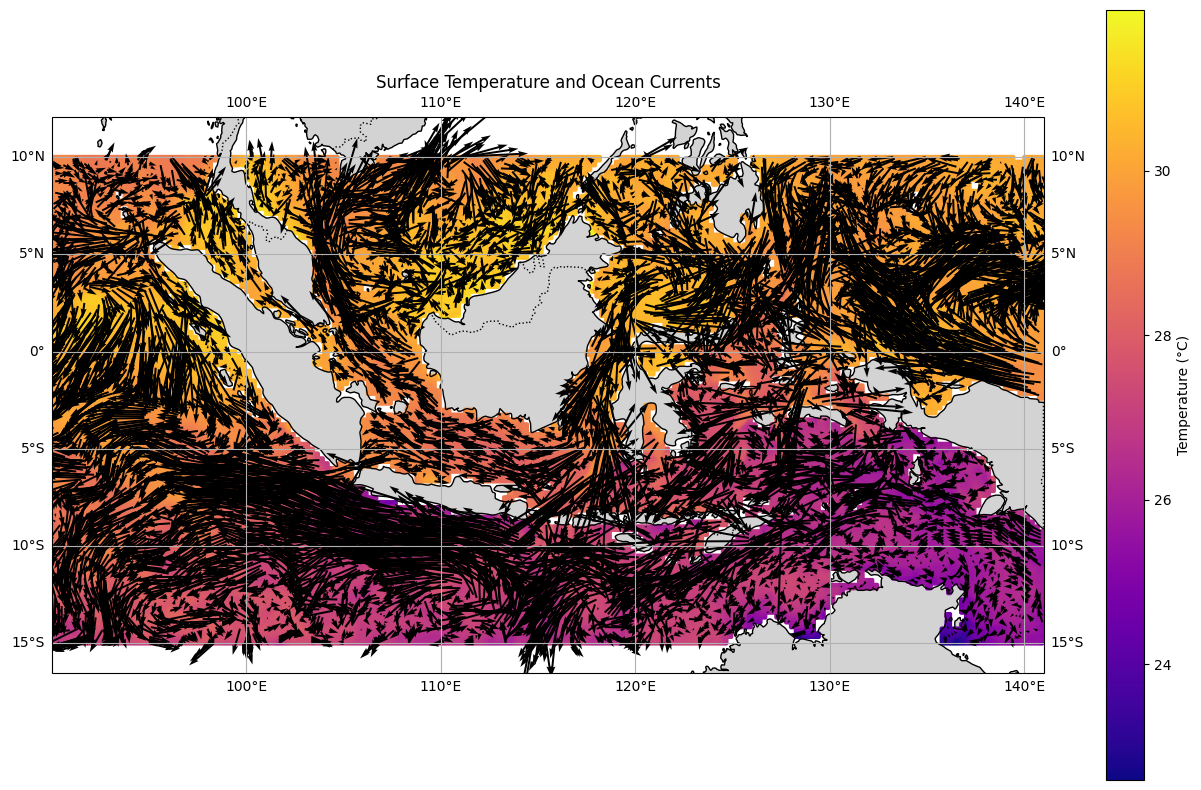

In [3]:
# Set up plot
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([90, 141, -15, 11])

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Plot temperature as heatmap
sc = ax.scatter(
    df['longitude'], df['latitude'], c=df['temperature'],
    cmap='plasma', s=5, transform=ccrs.PlateCarree()
)

# Plot velocity vectors (downsampled)
skip = 20  # change this to reduce arrow density
ax.quiver(
    df['longitude'][::skip], df['latitude'][::skip],
    df['u_velocity'][::skip], df['v_velocity'][::skip],
    scale=10, width=0.002, transform=ccrs.PlateCarree(), color='black'
)

plt.title("Surface Temperature and Ocean Currents")
plt.colorbar(sc, label="Temperature (°C)")
plt.show()


Rule-based approach dan melihat probabilitas tanpa model.

HSI shape: (301, 612)
Total points: 184212
High-suitability points: 19845


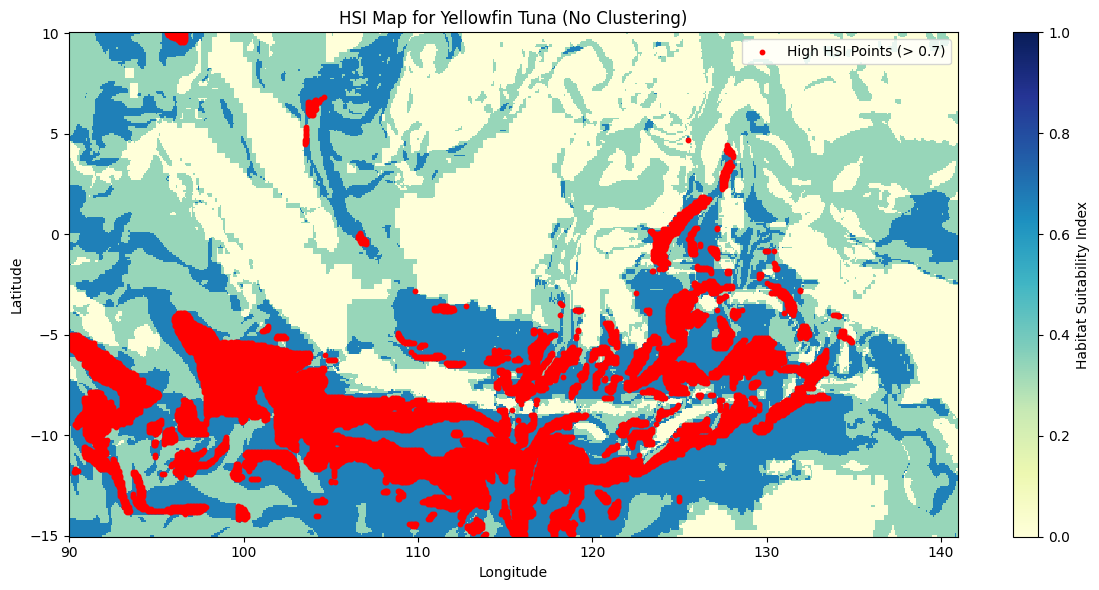

In [4]:
# Ini ga pake model apa-apa, cuman rule-based approach buat HSI
# === Load datasets === 
ds_temp = xr.open_dataset("dataset/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1754328683435.nc")
ds_chlor = xr.open_dataset("dataset/cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_1754328302683.nc")
ds_velocity = xr.open_dataset("dataset/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1754328993629.nc")

# === Select surface data ===
temp = ds_temp['thetao'].isel(time=0, depth=0)
chlor = ds_chlor['chl'].isel(time=0, depth=0)
u = ds_velocity['uo'].isel(time=0, depth=0)
v = ds_velocity['vo'].isel(time=0, depth=0)

# === Interpolate chlorophyll to temp grid ===
chlor_interp = chlor.interp(
    latitude=temp.latitude,
    longitude=temp.longitude,
    method="linear"
).fillna(0)

# === Compute current speed ===
current_speed = np.sqrt(u**2 + v**2)

# === Apply Yellowfin Tuna environmental filters ===
suitable_temp = (temp >= 26) & (temp <= 29)
suitable_chlor = (chlor_interp >= 0.15) & (chlor_interp <= 0.7)
suitable_current = (current_speed >= 0.3) & (current_speed <= 0.8)

# === Compute Habitat Suitability Index (HSI) ===
HSI = (suitable_temp.astype(float) + suitable_chlor.astype(float) + suitable_current.astype(float)) / 3

# === Extract high-HSI points ===
lat, lon = np.meshgrid(temp.latitude, temp.longitude, indexing='ij')
mask = HSI.values > 0.7
points = np.array([lon[mask], lat[mask]]).T

# === Print diagnostics ===
print("HSI shape:", HSI.shape)
print("Total points:", HSI.size)
print("High-suitability points:", np.sum(mask))

# === Plot HSI Heatmap + high-suitability points ===
plt.figure(figsize=(12, 6))
plt.pcolormesh(temp.longitude, temp.latitude, HSI, cmap='YlGnBu', shading='auto')
plt.colorbar(label='Habitat Suitability Index')
plt.scatter(points[:, 0], points[:, 1], color='red', s=10, label="High HSI Points (> 0.7)")
plt.title("HSI Map for Yellowfin Tuna (No Clustering)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

Melihat probabilitas melalui Clustering.

Clustering dari spatial dan HSI.


Cluster centroids (based on HSI and location):
            Latitude   Longitude    HSI
Cluster ID                             
0             -7.672  122.134003  0.702
1              4.675  101.122002  0.449
2             -8.716   99.582001  0.655
3            -10.433  126.973000  0.400
4              4.504  129.695007  0.418


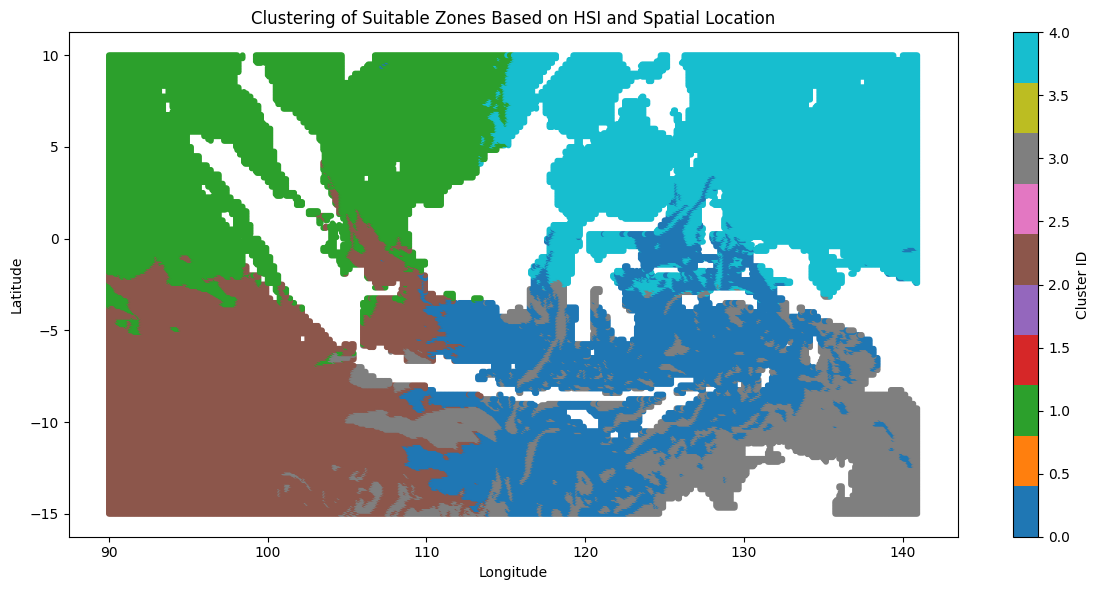

In [6]:
temp = ds_temp['thetao'].isel(time=0, depth=0)
chlor = ds_chlor['chl'].isel(time=0, depth=0)
u = ds_velocity['uo'].isel(time=0, depth=0)
v = ds_velocity['vo'].isel(time=0, depth=0)

# Interpolate chlorophyll and current data to match temp grid
chlor_interp = chlor.interp_like(temp)
u_interp = u.interp_like(temp)
v_interp = v.interp_like(temp)

# Create lat/lon grid
lat_vals = temp.latitude.values
lon_vals = temp.longitude.values
lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')

# --- Gaussian Suitability Function ---
def gaussian_suitability(x, optimal, sigma):
    return np.exp(-0.5 * ((x - optimal) / sigma) ** 2)

# --- Compute Suitability ---
temp_suit = gaussian_suitability(temp, optimal=28, sigma=1.5)
chlor_suit = gaussian_suitability(chlor_interp, optimal=0.7, sigma=0.4)
current_speed = np.sqrt(u_interp**2 + v_interp**2)
current_suit = gaussian_suitability(current_speed, optimal=0.4, sigma=0.2)

# --- Habitat Suitability Index (HSI) ---
hsi = (temp_suit * chlor_suit * current_suit) ** (1/3)  # geometric mean

# --- Mask high HSI points ---
mask = hsi.values > 0  # could use threshold like > 0.5
lat_points = lat_grid[mask]
lon_points = lon_grid[mask]
hsi_points = hsi.values[mask]

# --- Feature Matrix: [Latitude, Longitude, HSI] ---
features = np.stack([lat_points, lon_points, hsi_points], axis=1)

# --- Standardize ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Clustering ---
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# --- Inverse transform to get centroids ---
centroids_scaled = kmeans.cluster_centers_
centroids_real = scaler.inverse_transform(centroids_scaled)

# --- Create DataFrame for centroids ---
centroids_df = pd.DataFrame(
    centroids_real,
    columns=["Latitude", "Longitude", "HSI"]
)
centroids_df.index.name = "Cluster ID"

# --- Print the Centroids ---
print("\nCluster centroids (based on HSI and location):")
print(centroids_df.round(3))

# --- Plot the Clusters ---
plt.figure(figsize=(12, 6))
scatter = plt.scatter(lon_points, lat_points, c=labels, cmap='tab10', s=10)
plt.title("Clustering of Suitable Zones Based on HSI and Spatial Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()


Ngetes make TIF dan GEOJSON dari Apparent Fishing Activity

c:\CodeTools\Projek\Gemastik\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


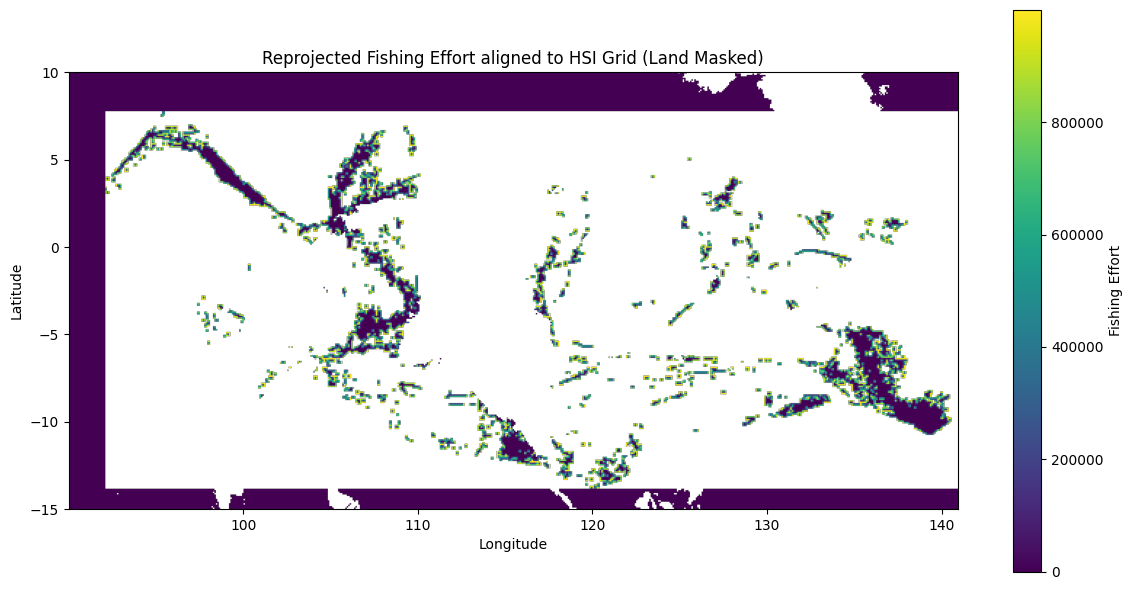

In [8]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

# === Load your HSI grid variables ===
# Assuming you already have: HSI (xarray.DataArray or np.array), lat_vals, lon_vals

# Example placeholders:
# lat_vals, lon_vals = np.linspace(-10, 10, 100), np.linspace(100, 120, 200)
# HSI = np.random.rand(len(lat_vals), len(lon_vals))

# === Open the Fishing Effort GeoTIFF ===
with rasterio.open("dataset/layer-activity-data-0/public-global-fishing-effort-v3.0.tif") as src:
    downloaded_data = src.read(1)  # first band
    downloaded_crs = src.crs
    downloaded_transform = src.transform
    downloaded_bounds = src.bounds
    downloaded_nodata = src.nodata

# === Create transform for HSI grid ===
transform_hsi = from_bounds(
    west=lon_vals.min(),
    south=lat_vals.min(),
    east=lon_vals.max(),
    north=lat_vals.max(),
    width=HSI.shape[1],
    height=HSI.shape[0]
)

# === Prepare empty array for resampled data ===
downloaded_resampled = np.zeros_like(HSI.values, dtype=np.float32)

# === Reproject (resample) GeoTIFF to HSI grid ===
reproject(
    source=downloaded_data,
    destination=downloaded_resampled,
    src_transform=downloaded_transform,
    src_crs=downloaded_crs,
    dst_transform=transform_hsi,
    dst_crs="EPSG:4326",
    resampling=Resampling.bilinear
)

# === Mask land using coastline shapefile from cartopy ===
# Land will be set to NaN so it doesn't affect model
import shapely.geometry as sgeom
import geopandas as gpd
from shapely.ops import unary_union
import cartopy.io.shapereader as shpreader

# Load natural earth coastline at 10m resolution
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='physical',
                                      name='land')
land_geom = unary_union(list(shpreader.Reader(shpfilename).geometries()))

# Create mask for land
land_mask = np.zeros_like(downloaded_resampled, dtype=bool)
for i, lat in enumerate(lat_vals):
    for j, lon in enumerate(lon_vals):
        point = sgeom.Point(lon, lat)
        if land_geom.contains(point):
            land_mask[i, j] = True

# Apply mask (land → NaN)
downloaded_resampled = np.where(land_mask, np.nan, downloaded_resampled)

# Also mask nodata values from the source
if downloaded_nodata is not None:
    downloaded_resampled[downloaded_resampled == downloaded_nodata] = np.nan

# === Plot to verify alignment ===
plt.figure(figsize=(12, 6))
plt.imshow(downloaded_resampled, origin='upper',
           extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
           cmap='viridis')
plt.title("Reprojected Fishing Effort aligned to HSI Grid (Land Masked)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Fishing Effort')
plt.tight_layout()
plt.show()


Reproject yang bener.

In [30]:
import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import Point
from shapely.prepared import prep

# --- Step 1: Load datasets ---
# Assuming ds_temp, ds_chlor, ds_velocity already loaded

temp = ds_temp['thetao'].isel(time=0, depth=0)
chlor = ds_chlor['chl'].isel(time=0, depth=0)
u = ds_velocity['uo'].isel(time=0, depth=0)
v = ds_velocity['vo'].isel(time=0, depth=0)

# --- Step 2: Interpolate chlorophyll and currents to temp grid ---
chlor_interp = chlor.interp_like(temp)
u_interp = u.interp_like(temp)
v_interp = v.interp_like(temp)

lat_vals = temp.latitude.values
lon_vals = temp.longitude.values
lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')

# --- Step 3: Gaussian suitability ---
def gaussian_suitability(x, optimal, sigma):
    return np.exp(-0.5 * ((x - optimal) / sigma) ** 2)

temp_suit = gaussian_suitability(temp, optimal=28, sigma=1.5)
chlor_suit = gaussian_suitability(chlor_interp, optimal=0.7, sigma=0.4)
current_speed = np.sqrt(u_interp**2 + v_interp**2)
current_suit = gaussian_suitability(current_speed, optimal=0.4, sigma=0.2)

# --- Step 4: Compute HSI ---
hsi = (temp_suit * chlor_suit * current_suit) ** (1/3)  # geometric mean

# --- Step 5: Mask land using Natural Earth ---
shapefile_path = "dataset/countries/ne_110m_admin_0_countries.zip"
world = gpd.read_file(shapefile_path)
land_union = world.unary_union

mask_land = np.zeros(hsi.shape, dtype=bool)
for i in range(lat_grid.shape[0]):
    for j in range(lat_grid.shape[1]):
        if land_union.contains(Point(lon_grid[i, j], lat_grid[i, j])):
            mask_land[i, j] = True

hsi_masked = hsi.where(~mask_land)  # keep only ocean pixels

# --- Step 6: Save to GeoTIFF ---
# Define transform (lon-lat grid, pixel size)
pixel_size_x = lon_vals[1] - lon_vals[0]
pixel_size_y = lat_vals[1] - lat_vals[0]
transform = from_origin(lon_vals.min(), lat_vals.max(), pixel_size_x, abs(pixel_size_y))

output_file = "hsi_map.tif"
with rasterio.open(
    output_file,
    'w',
    driver='GTiff',
    height=hsi_masked.shape[0],
    width=hsi_masked.shape[1],
    count=1,
    dtype=hsi_masked.dtype,
    crs="EPSG:4326",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(hsi_masked.values, 1)

print(f"HSI GeoTIFF saved to {output_file}")


C:\Users\Muhammad Fachri\AppData\Local\Temp\ipykernel_19300\3751966585.py:41: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_union = world.unary_union


HSI GeoTIFF saved to hsi_map.tif


In [35]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.plot import plotting_extent
import numpy as np

hsi_tif = "dataset/layer-activity-data-0/hsi_map.tif"
fishing_tif = "dataset/layer-activity-data-0/public-global-fishing-effort-v3.0.tif"
out_fishing_on_hsi = "dataset/layer-activity-data-0/fishing_on_hsi.tif"

# open HSI as reference
with rasterio.open(hsi_tif) as ref:
    ref_meta = ref.meta.copy()
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_shape = (ref.height, ref.width)

# read fishing input
with rasterio.open(fishing_tif) as src:
    src_data = src.read(1)
    src_transform = src.transform
    src_crs = src.crs
    src_nodata = src.nodata

# prepare destination array
dst = np.full(ref_shape, np.nan, dtype=np.float32)

# reproject fishing onto HSI grid using nearest or bilinear depending on data
reproject(
    source=src_data,
    destination=dst,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=ref_transform,
    dst_crs=ref_crs,
    resampling=Resampling.bilinear  # bilinear for smoothness, nearest if categorical
)

# optionally set src nodata to NaN
if src_nodata is not None:
    dst[dst == src_nodata] = np.nan

# save result
out_meta = ref_meta
out_meta.update(dtype="float32", count=1, nodata=np.nan)
with rasterio.open(out_fishing_on_hsi, "w", **out_meta) as dstf:
    dstf.write(dst.astype(np.float32), 1)

print("Saved fishing reprojected to HSI grid:", out_fishing_on_hsi)


Saved fishing reprojected to HSI grid: dataset/layer-activity-data-0/fishing_on_hsi.tif


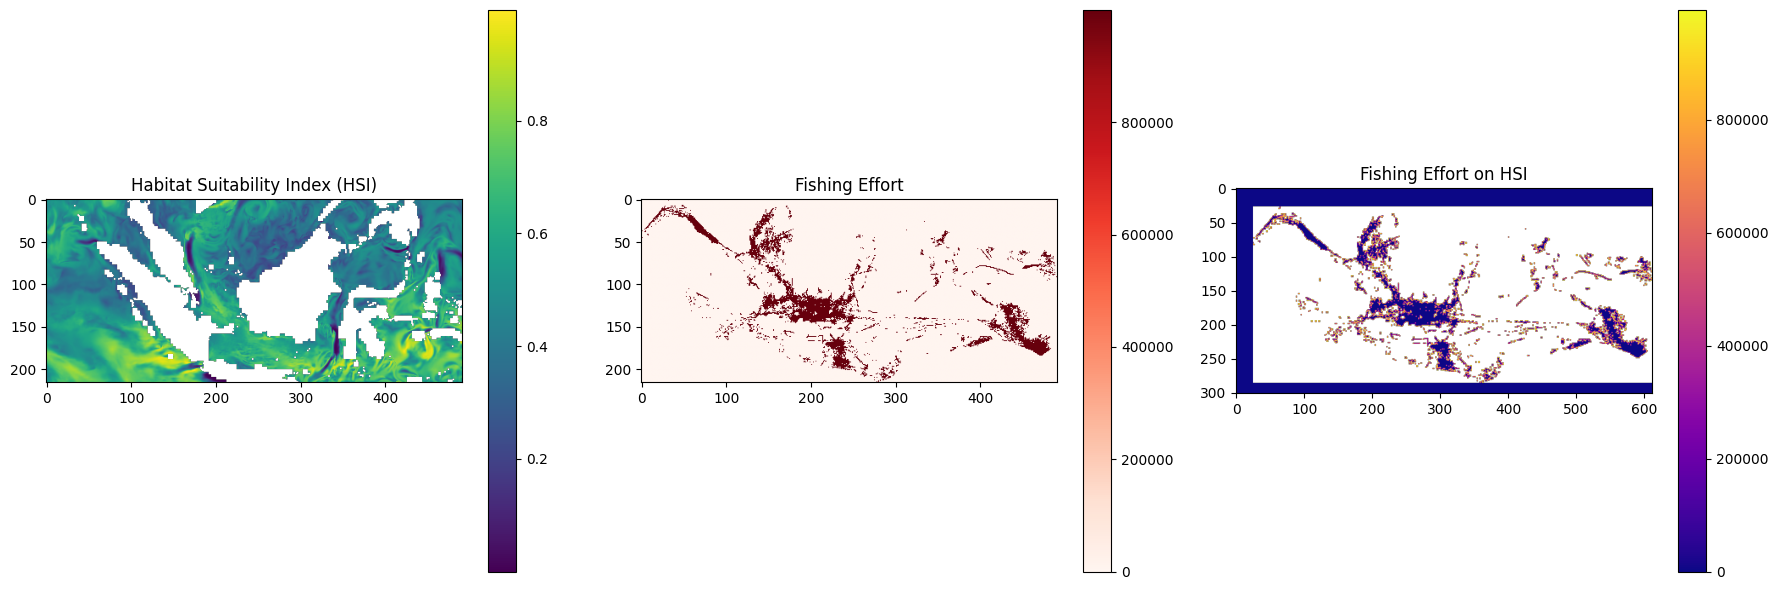

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

# File paths
hsi_file = "dataset/layer-activity-data-0/hsi_map.tif"
fishing_effort_file = "dataset/layer-activity-data-0/public-global-fishing-effort-v3.0.tif"
fishing_on_hsi_file = "dataset/layer-activity-data-0/fishing_on_hsi.tif"

# Load rasters
hsi = rasterio.open(hsi_file)
fishing_effort = rasterio.open(fishing_effort_file)
fishing_on_hsi = rasterio.open(fishing_on_hsi_file)

# Read data
hsi_data = hsi.read(1)
fishing_effort_data = fishing_effort.read(1)
fishing_on_hsi_data = fishing_on_hsi.read(1)

hsi_data = np.flipud(hsi_data)

# Mask NaNs or invalid values
hsi_data = np.where(hsi_data < 0, np.nan, hsi_data)
fishing_effort_data = np.where(fishing_effort_data < 0, np.nan, fishing_effort_data)
fishing_on_hsi_data = np.where(fishing_on_hsi_data < 0, np.nan, fishing_on_hsi_data)

# Plot side-by-side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im1 = axs[0].imshow(hsi_data, cmap='viridis')
axs[0].set_title("Habitat Suitability Index (HSI)")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(fishing_effort_data, cmap='Reds')
axs[1].set_title("Fishing Effort")
plt.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(fishing_on_hsi_data, cmap='plasma')
axs[2].set_title("Fishing Effort on HSI")
plt.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()


In [56]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import numpy as np

# Input file paths
hsi_file = "dataset/layer-activity-data-0/hsi_map.tif"
fishing_effort_file = "dataset/layer-activity-data-0/public-global-fishing-effort-v3.0.tif"
output_file = "dataset/layer-activity-data-0/fishing_on_hsi_cropped.tif"

# Get fishing effort bounds
with rasterio.open(fishing_effort_file) as fishing:
    fishing_bounds = fishing.bounds
    fishing_crs = fishing.crs
    fishing_data = fishing.read(1)
    fishing_profile = fishing.profile

# Create geometry from fishing raster bounds
geom = [box(*fishing_bounds)]

# Crop HSI to fishing bounds
with rasterio.open(hsi_file) as hsi:
    hsi_cropped, hsi_transform = mask(hsi, geom, crop=True)
    hsi_meta = hsi.meta.copy()
    hsi_meta.update({
        "height": hsi_cropped.shape[1],
        "width": hsi_cropped.shape[2],
        "transform": hsi_transform
    })
    hsi_cropped = hsi_cropped[0]  # first band only

# Mask invalid/negative values
hsi_cropped = np.where(hsi_cropped < 0, np.nan, hsi_cropped)
fishing_data = np.where(fishing_data < 0, np.nan, fishing_data)

# Save cropped HSI
with rasterio.open(output_file, "w", **hsi_meta) as dst:
    dst.write(hsi_cropped, 1)

print(f"Cropped HSI saved to {output_file}")


Cropped HSI saved to dataset/layer-activity-data-0/fishing_on_hsi_cropped.tif


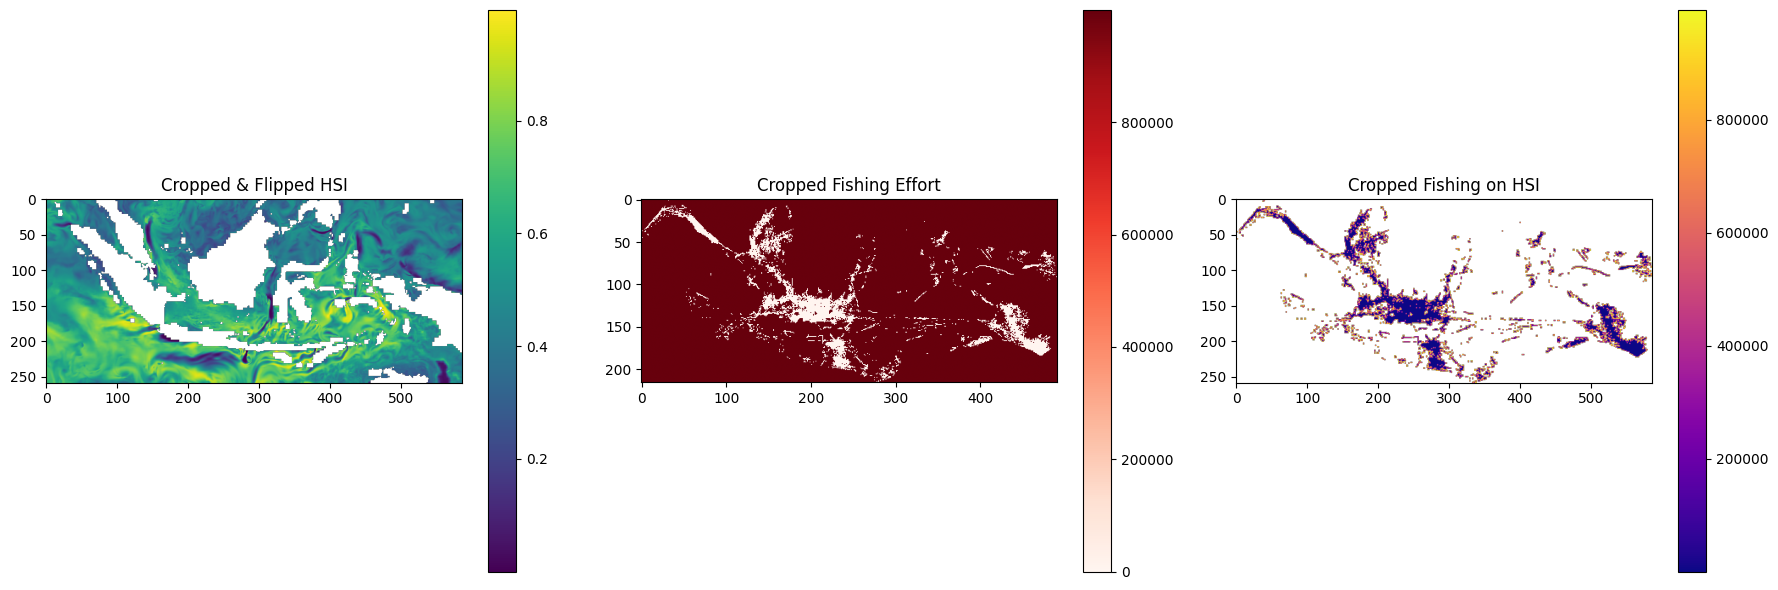

Saved cropped & flipped HSI → dataset/layer-activity-data-0/hsi_map_cropped_flipped.tif
Saved cropped Fishing Effort → dataset/layer-activity-data-0/fishing_effort_cropped.tif
Saved cropped Fishing on HSI → dataset/layer-activity-data-0/fishing_on_hsi_cropped.tif


In [59]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# File paths
hsi_file = "dataset/layer-activity-data-0/hsi_map.tif"
fishing_effort_file = "dataset/layer-activity-data-0/public-global-fishing-effort-v3.0.tif"
fishing_on_hsi_file = "dataset/layer-activity-data-0/fishing_on_hsi.tif"

# Output paths
hsi_cropped_file = "dataset/layer-activity-data-0/hsi_map_cropped_flipped.tif"
fishing_effort_cropped_file = "dataset/layer-activity-data-0/fishing_effort_cropped.tif"
fishing_on_hsi_cropped_file = "dataset/layer-activity-data-0/fishing_on_hsi_cropped.tif"

# Load reference raster (we’ll use fishing effort as the crop extent)
with rasterio.open(fishing_effort_file) as ref_src:
    ref_bounds = ref_src.bounds
    ref_transform = ref_src.transform
    ref_crs = ref_src.crs
    ref_shape = ref_src.read(1).shape

def crop(src_file, ref_bounds):
    with rasterio.open(src_file) as src:
        # Calculate window based on reference bounds
        window = rasterio.windows.from_bounds(*ref_bounds, transform=src.transform)
        # Read data in window (single band assumed)
        data = src.read(1, window=window)
        # Mask invalid values (<0) with NaN
        data = np.where(data < 0, np.nan, data)
        # Copy profile and update for cropped window
        profile = src.profile.copy()
        profile.update({
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": rasterio.windows.transform(window, src.transform),
            "crs": src.crs
        })
        return data, profile

def crop_and_save(src_file, out_file, ref_bounds):
    data, profile = crop(src_file, ref_bounds)
    with rasterio.open(out_file, "w", **profile) as dst:
        dst.write(data, 1)
    return data

# Crop HSI, then flip vertically, then save
hsi_cropped_data, hsi_profile = crop(hsi_file, ref_bounds)
hsi_cropped_data_flipped = np.flipud(hsi_cropped_data)
with rasterio.open(hsi_cropped_file, "w", **hsi_profile) as dst:
    dst.write(hsi_cropped_data_flipped, 1)

# Crop and save fishing effort and fishing_on_hsi (no flipping)
fishing_effort_cropped = crop_and_save(fishing_effort_file, fishing_effort_cropped_file, ref_bounds)
fishing_on_hsi_cropped = crop_and_save(fishing_on_hsi_file, fishing_on_hsi_cropped_file, ref_bounds)

# Display results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im1 = axs[0].imshow(hsi_cropped_data_flipped, cmap="viridis")
axs[0].set_title("Cropped & Flipped HSI")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(fishing_effort_cropped, cmap="Reds")
axs[1].set_title("Cropped Fishing Effort")
plt.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(fishing_on_hsi_cropped, cmap="plasma")
axs[2].set_title("Cropped Fishing on HSI")
plt.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

print(f"Saved cropped & flipped HSI → {hsi_cropped_file}")
print(f"Saved cropped Fishing Effort → {fishing_effort_cropped_file}")
print(f"Saved cropped Fishing on HSI → {fishing_on_hsi_cropped_file}")


In [62]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# Load HSI data
with rasterio.open(hsi_cropped_file) as src_hsi:
    hsi_data = src_hsi.read()  # shape: (bands, height, width)
    hsi_profile = src_hsi.profile

# Load and resample fishing effort data to HSI shape
with rasterio.open(fishing_effort_cropped_file) as src_fish:
    fishing_effort_resampled = src_fish.read(
        1,
        out_shape=(src_hsi.height, src_hsi.width),
        resampling=Resampling.bilinear
    )

    # Use HSI's transform for alignment if saving later
    fishing_effort_transform = hsi_profile['transform']

# Now fishing_effort_resampled and hsi_data have the same height and width
print("Resampled Fishing Effort shape:", fishing_effort_resampled.shape)
print("HSI shape:", hsi_data.shape)


Resampled Fishing Effort shape: (259, 587)
HSI shape: (1, 259, 587)


In [68]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# File paths
hsi_cropped_file = "dataset/layer-activity-data-0/final/hsi_map_cropped_flipped.tif"
fishing_effort_cropped_file = "dataset/layer-activity-data-0/final/fishing_effort_cropped.tif"
prediction_file = "dataset/layer-activity-data-0/final/fishing_effort_predicted.tif"

# Load HSI data (bands x height x width)
with rasterio.open(hsi_cropped_file) as src_hsi:
    hsi_data = src_hsi.read()
    hsi_profile = src_hsi.profile

# Resample fishing effort to HSI's shape
with rasterio.open(fishing_effort_cropped_file) as src_fish:
    fishing_effort_resampled = src_fish.read(
        1,
        out_shape=(src_hsi.height, src_hsi.width),
        resampling=Resampling.bilinear
    )

# Prepare data for modeling
bands, height, width = hsi_data.shape

# Flatten spatial dimensions: samples x features
X = hsi_data.reshape(bands, height * width).T  # shape: (pixels, bands)
y = fishing_effort_resampled.flatten()         # shape: (pixels,)

# Filter valid pixels where fishing effort is not nan and >= 0
valid_mask = (~np.isnan(y)) & (y >= 0)
X_valid = X[valid_mask]
y_valid = y[valid_mask]

print(f"Valid samples: {X_valid.shape[0]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

# Train Random Forest regression
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2: {r2:.4f}")

# Predict for all valid pixels in the image
y_pred_full = model.predict(X_valid)

# Create full prediction map with NaNs for invalid pixels
fishing_effort_pred_map = np.full(y.shape, np.nan)
fishing_effort_pred_map[valid_mask] = y_pred_full
fishing_effort_pred_map = fishing_effort_pred_map.reshape(height, width)

# Save predicted fishing effort as GeoTIFF
profile = hsi_profile.copy()
profile.update(dtype=rasterio.float32, count=1, compress='lzw')

with rasterio.open(prediction_file, "w", **profile) as dst:
    dst.write(fishing_effort_pred_map.astype(rasterio.float32), 1)

print(f"Prediction map saved to: {prediction_file}")


Valid samples: 152033
Test RMSE: 391861.6992
Test R2: -0.3413
Prediction map saved to: dataset/layer-activity-data-0/final/fishing_effort_predicted.tif


In [67]:
print("HSI shape (bands, height, width):", hsi_data.shape)
print("Fishing effort shape (height, width):", fishing_effort.shape)


HSI shape (bands, height, width): (1, 259, 587)
Fishing effort shape (height, width): (216, 491)


Pemodelan dengan Apparent Fishing Activity

In [ ]:
current_magnitude = np.sqrt(ds_velocity['uo']**2 + ds_velocity['vo']**2)

# Aggregate to annual mean (assumes 'time' dimension covers the full year)
temp_annual = ds_temp['thetao'].sel(depth=0, method='nearest').mean(dim='time')
chlor_annual = ds_chlor['chl'].mean(dim='time')
chlor_annual = chlor_annual.squeeze() 
current_annual = current_magnitude.mean(dim='time')
current_annual = current_annual.squeeze()
fishing_effort = downloaded_resampled 

temp_annual = temp_annual.rename({'latitude': 'lat', 'longitude': 'lon'})
current_annual = current_annual.rename({'latitude': 'lat', 'longitude': 'lon'})

fishing_effort = xr.DataArray(
    fishing_effort,
    dims=("lat", "lon"),
    coords={
        "lat": temp_annual["lat"],
        "lon": temp_annual["lon"]
    }
)

# Buat chlor_annual jadi xarray dengan koordinat yang bisa diinterpolasi
chlor_da = xr.DataArray(
    chlor_annual.values,
    dims=("lat", "lon"),
    coords={
        "lat": ds_chlor["lat"],
        "lon": ds_chlor["lon"]
    }
)

# Interpolasi ke grid temp_annual
chlor_interp = chlor_da.interp_like(temp_annual, method="linear")
chlor_interp = chlor_interp.squeeze()

mask = np.isfinite(temp_annual.values) & (fishing_effort > 0)

print(temp_annual.shape)       # (301, 612)
print(chlor_interp.shape)      # (301, 612)
print(current_annual.shape)    # (301, 612)
print(HSI.shape)               # (301, 612)
print(fishing_effort.shape)    # (301, 612)

X = np.stack([
    temp_annual.values.flatten(),
    chlor_interp.values.flatten(),
    current_annual.values.flatten(),
    HSI.values.flatten(),
], axis=1)

y = fishing_effort.values.flatten()

X = X[mask.values.flatten()]
y = y[mask.values.flatten()]

KeyError: "No variable named 'lat'. Variables on the dataset include ['chl', 'time', 'depth', 'latitude', 'longitude']"

In [73]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. Imputasi
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_np)

# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. Polynomial expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# 4. Train-test split
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# 5. Train model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# 6. Predict & Evaluate
y_pred = model.predict(X_test_poly)
np.sqrt(mean_squared_error(y_test, y_pred))
print("Polynomial Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Polynomial Linear R²:", r2_score(y_test, y_pred))


Polynomial Linear RMSE: 211041.91922543335
Polynomial Linear R²: 0.03139668256135619


In [74]:
# Tetap pakai data X_scaled hasil imputasi + scaling (tanpa polynomial)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 391893.6600404035
Random Forest R²: -0.34153563796802033


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Example: create bins for y_test and y_pred_rf
bins = [0, 1000, 10000, np.inf]  # adjust thresholds to meaningful ranges
labels = [0, 1, 2]  # class labels

# Bin true and predicted values
y_test_binned = np.digitize(y_test, bins) - 1
y_pred_binned = np.digitize(y_pred_rf, bins) - 1

# Confusion matrix
cm = confusion_matrix(y_test_binned, y_pred_binned)
print("Confusion Matrix:\n", cm)

# Optional: classification report with precision, recall, f1-score
print(classification_report(y_test_binned, y_pred_binned, target_names=['Low', 'Medium', 'High']))


In [69]:
hgb_model = HistGradientBoostingRegressor(random_state=42)
hgb_model.fit(X_train, y_train)

y_pred_hgb = hgb_model.predict(X_test)
print("HistGradientBoosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hgb)))
print("HistGradientBoosting R²:", r2_score(y_test, y_pred_hgb))

param_grid = {
    "max_iter": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [None, 5, 10],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best RMSE on validation:", -grid.best_score_)

# Evaluate on test set
y_pred_best = grid.predict(X_test)
print("Test RMSE (best HGB):", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Test R²:", r2_score(y_test, y_pred_best))



HistGradientBoosting RMSE: 335387.0121327598
HistGradientBoosting R²: 0.01744194568669033
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'max_iter': 100}
Best RMSE on validation: 335265.7730419132
Test RMSE (best HGB): 335321.1741542385
Test R²: 0.01782766895147192


In [70]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define parameter grid for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the base model
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # number of parameter settings sampled
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'  # minimize MSE
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best params
print("Best hyperparameters:", random_search.best_params_)

# Predict & evaluate on test set using best estimator
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print(f"Tuned RF RMSE: {rmse:.4f}")
print(f"Tuned RF R²: {r2:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\CodeTools\Projek\Gemastik\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
60 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\CodeTools\Projek\Gemastik\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\CodeTools\Projek\Gemastik\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\CodeTools\Projek\Gemastik\.venv\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "c:

Best hyperparameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 10, 'bootstrap': True}
Tuned RF RMSE: 335396.4204
Tuned RF R²: 0.0174


Feature Importance buat efisiensi model.

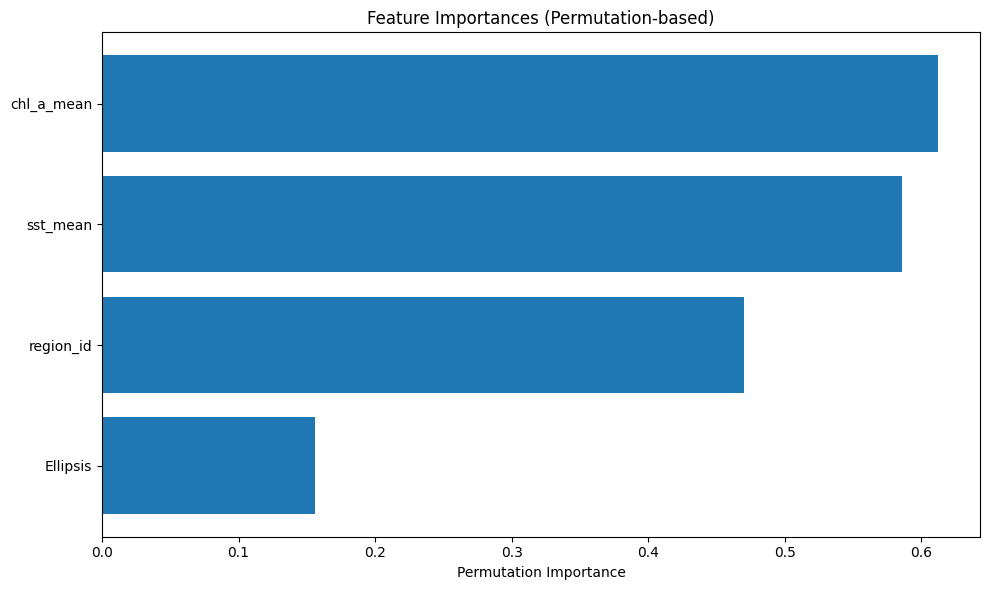

In [ ]:
# Pakai model terbaik dari GridSearchCV
result = permutation_importance(grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Ambil dan urutkan
importances = result.importances_mean
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
feature_names = ['sst_mean', 'chl_a_mean', 'region_id', ...]  # isi sesuai fitur
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importances (Permutation-based)")
plt.tight_layout()
plt.show()


In [ ]:
# Gunakan nama fitur sesuai jumlah kolom
feature_names_original = ['sst_mean', 'chl_a_mean', 'region_id', 'year']  # ← 4 nama fitur

# Buat fitur polinomial
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Ambil nama-nama fitur hasil ekspansi
feature_names = poly.get_feature_names_out(input_features=feature_names_original)

# Split data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit model
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train_poly, y_train)

# Importance via permutation
result = permutation_importance(model, X_test_poly, y_test, n_repeats=10, random_state=42)

# DataFrame untuk hasil importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Tampilkan 10 fitur teratas
print(importance_df.head(10))


                 Feature  Importance
0               sst_mean    0.212539
1             chl_a_mean    0.153624
5    sst_mean chl_a_mean    0.128458
4             sst_mean^2    0.108165
9   chl_a_mean region_id    0.073979
12        region_id year    0.070411
7          sst_mean year    0.063165
11           region_id^2    0.058121
6     sst_mean region_id    0.055213
8           chl_a_mean^2    0.049596


Pemodelan dengan XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


XGBoost RMSE: 170226.11112100014
XGBoost R²: 0.36982546149749007


Hyperparameter XGBoost.

In [ ]:
param_grid = {
    "n_estimators": [100, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8]
}

grid_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train_scaled, y_train)

print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best Validation RMSE:", -grid_xgb.best_score_)

# Final model
best_xgb = grid_xgb.best_estimator_
y_pred_best = best_xgb.predict(X_test_scaled)

print("Test RMSE (best XGBoost):", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Test R² (best XGBoost):", r2_score(y_test, y_pred_best))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
Best Validation RMSE: 168718.8553067355
Test RMSE (best XGBoost): 163741.92675302006
Test R² (best XGBoost): 0.4169198060211091
